In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


def name_dataset(df, name):
    df['dataset'] = name
    return df

def left_join_hie(df):
    # Read the file
    comparison = {'dataset': ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin'],
                  'comparison': [0.22, 0.40, 0.23, 0.16, 0.31, 0.50, 0.077, 0.12, 0.20]}
    comparison = pd.DataFrame(comparison)

    # Merge the two dataframes
    df = pd.merge(df, comparison, on='dataset', how='left')

    return df

def plot_num_iterations_vs_output(df, output_var, num_mutants_per_round, ax=None, comparison=False):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    # Filter the DataFrame based on num_mutants_per_round
    filtered_df = df[df['num_mutants_per_round'] == num_mutants_per_round]

    # Left join the comparison values
    filtered_df = left_join_hie(filtered_df)

    # Create a color map for datasets
    color_map = plt.get_cmap('tab20')

    # Get unique datasets from the DataFrame
    datasets = filtered_df['dataset'].unique()

    # Plot each dataset as a separate line
    for i, dataset in enumerate(datasets):
        dataset_df = filtered_df[filtered_df['dataset'] == dataset]
        x_values = dataset_df['num_iterations']
        y_values = dataset_df[output_var]
        color = color_map(i)
        label = f'{dataset}'
        ax.plot(x_values, y_values, color=color, marker='o', label=label)

        if comparison:
            comparisons = dataset_df['comparison']
            for j, comparison_value in enumerate(comparisons):
                if not np.isnan(comparison_value):
                    # Create an interpolation function for the line
                    line_interp = interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')

                    # Find the intersection point with the comparison value
                    intersection_x = np.interp(comparison_value, y_values, x_values)
                    intersection_y = line_interp(intersection_x)

                    # Plot the dash marker at the intersection point

                    ax.scatter(intersection_x, intersection_y, color='black', s=200, marker='_', zorder=5, label='_nolegend_')


    # Set plot labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(output_var)
    ax.set_title(f'{output_var} vs. Number of Iterations (num_mutants_per_round={num_mutants_per_round}), esm2')

    # Add legend to the right side of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot if it was newly created
    if ax is None:
        plt.show()

def generate_plots(esm="esm1b"):
    file_names_list = ["kelsic", "brenan", "stiffler", "markin", "giacomelli", "jones", "haddox", "doud", "lee"]
    individual_dfs = []

    for file_name in file_names_list:
        # Read the file
        if esm == "esm1b":
            file_path = f"{file_name}_{esm}_t33_650M_UR50S_results.csv"
        else:
            file_path = f"{file_name}_{esm}_t33_650M_UR50D_results.csv"
        individual_df = pd.read_csv(file_path)

        # Rename the columns
        individual_df = name_dataset(individual_df, file_name)

        # Save the scaled dataframe in the list
        individual_dfs.append(individual_df)

    # Concatenate all the scaled dataframes
    df = pd.concat(individual_dfs)

    fig, axes = plt.subplots(3, 1, figsize=(10, 18))

    # Plot 1
    plot_num_iterations_vs_output(df, 'last_median_fitness_scaled', num_mutants_per_round=16, ax=axes[0], comparison=False)
    axes[0].set_title('Median scaled last round fitness (0-1)')

    # Plot 2
    plot_num_iterations_vs_output(df, 'last_top_fitness_scaled', num_mutants_per_round=16, ax=axes[1], comparison=False)
    axes[1].set_title('Top scaled last round fitness (0-1)')

    # Plot 3
    plot_num_iterations_vs_output(df, 'last_fitness_binary_percentage', num_mutants_per_round=16, ax=axes[2], comparison=True)
    axes[2].set_title('Last round percent high fitness (0-100%)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the top margin to make room for the overarching title
    fig.suptitle(f"Metrics across rounds of simulated directed evolution ({esm})", fontsize=16, y=0.98)  # Set y to control the vertical position
    plt.show()

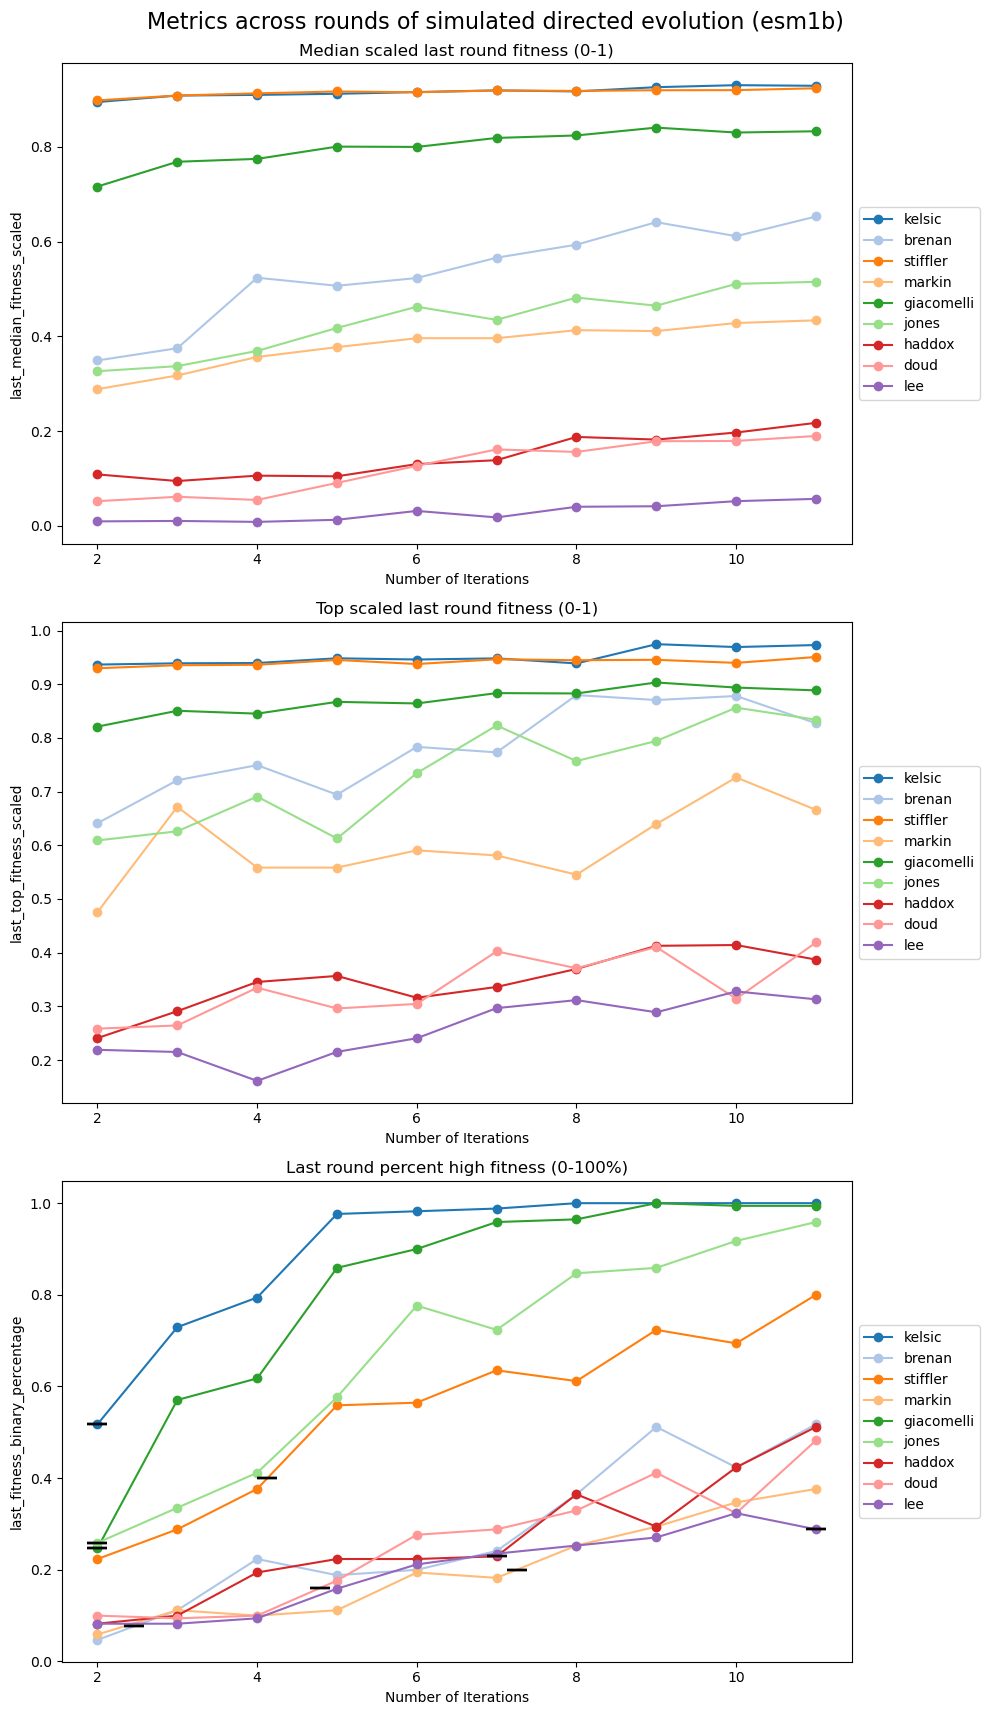

In [63]:
generate_plots(esm="esm1b")

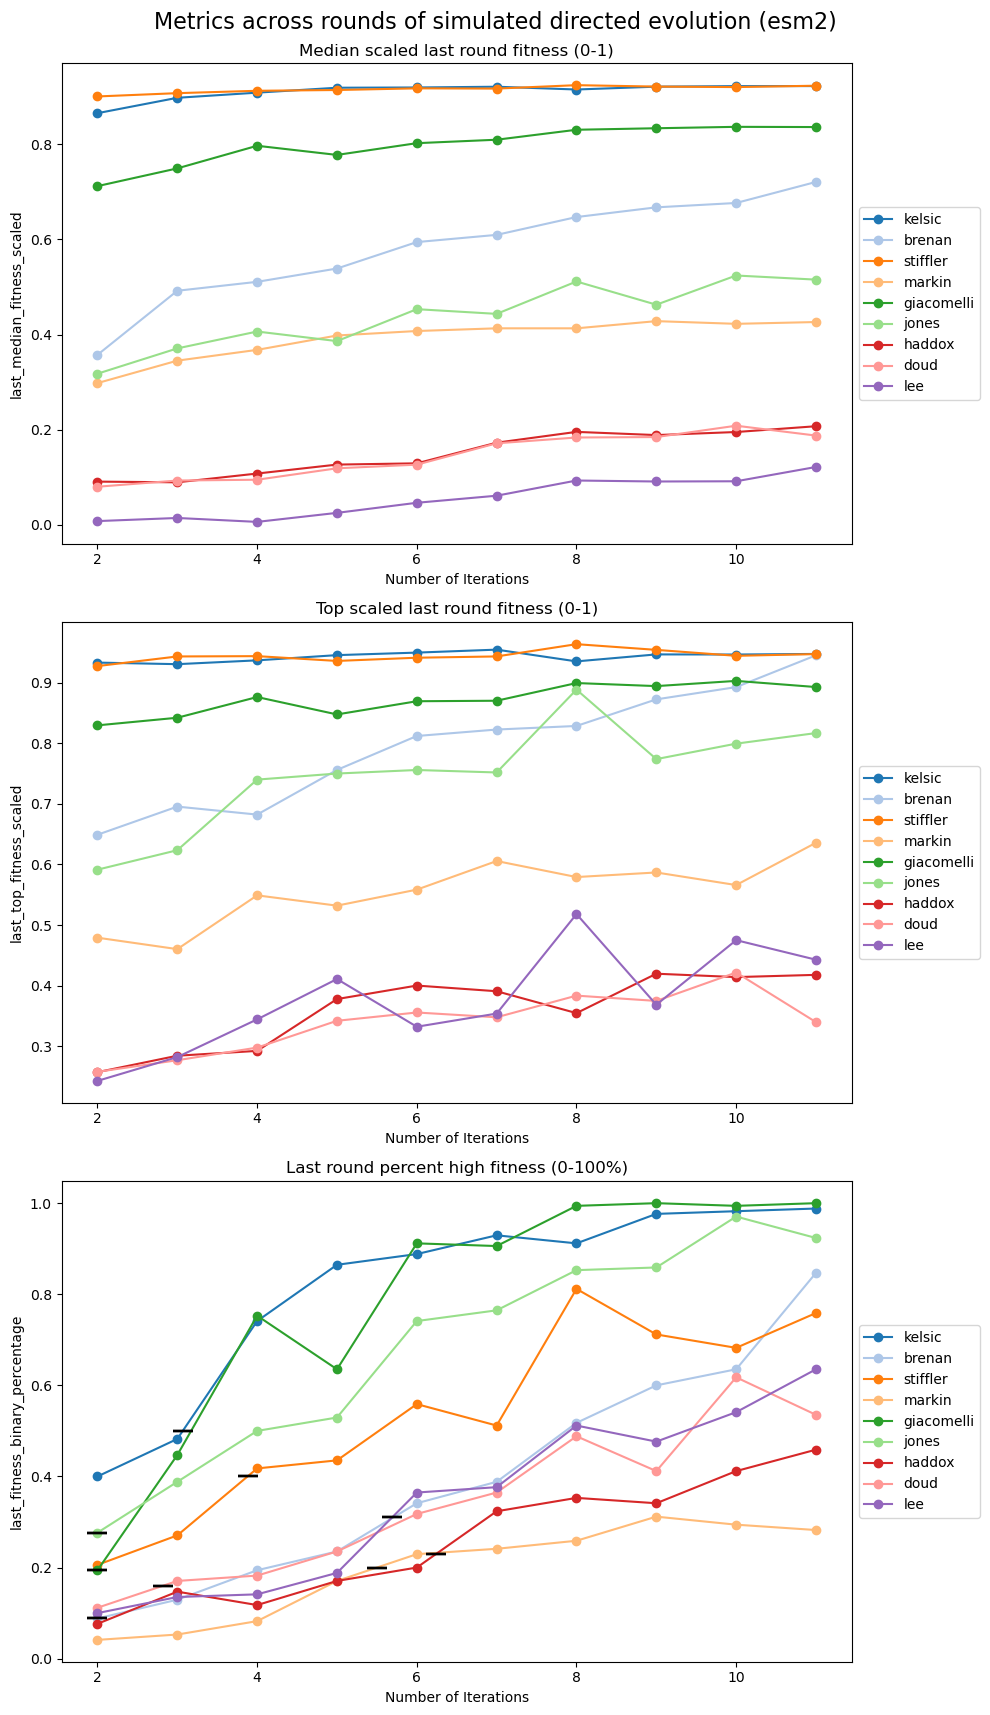

In [64]:
generate_plots(esm="esm2")